# Домашнее задание 3: Улучшенная сверточная нейронная сеть для MNIST

**Цель:** побить бейзлайн 0.9747

**В этом ноутбуке:**
- Использование Adam вместо SGD
- Альтернативная функция потерь (MSELoss с one-hot кодированием)
- Улучшенная архитектура CNN с различными параметрами
- Полное логгирование метрик и визуализация
- Подсчет обучаемых параметров
- Эксперименты с различными конфигурациями

---

## 1. Импорт необходимых библиотек

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch версия: {torch.__version__}")
print(f"Torchvision версия: {torchvision.__version__}")
print(f"CUDA доступна: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA устройство (карточка сюююда): {torch.cuda.get_device_name(0)}")

PyTorch версия: 2.8.0+cu129
Torchvision версия: 0.23.0+cu129
CUDA доступна: True
CUDA устройство (карточка сюююда): NVIDIA GeForce RTX 5060


## 2. Настройка воспроизводимости результатов

In [2]:
def seed_everywhere(seed):
    """Функция для фиксации seed для воспроизводимости результатов"""
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    print(f"Установлен seed: {seed}")

# устанавливаем seed для воспроизводимости
seed = 52
seed_everywhere(seed)

Установлен seed: 52


## 3. Правильное разделение данных (исправление утечки данных)

**Важная проблема:** В исходном коде использовался test set MNIST как validation, что является data leakage

**Почему нельзя использовать test set для validation:**
- Test set (train=False) предназначен для финальной оценки модели
- Если мы используем его для подбора архитектуры, гиперпараметров или early stopping, то подгоняем модель под test
- Это приводит к переоценке качества модели и неверным выводам
- Результаты на "новых" данных будут хуже, чем ожидается

**Правильный подход:**
- Train (80% от train=True) — для обучения модели  
- Validation (20% от train=True) — для подбора архитектуры и гиперпараметров
- Test (train=False) — только для финальной оценки, используется один раз в конце

In [ ]:
# Вычисляем статистики для нормализации
temp_dataset = torchvision.datasets.MNIST(
    './mnist/',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

data_loader = torch.utils.data.DataLoader(temp_dataset, batch_size=1000, shuffle=False)
mean = 0.0
std = 0.0
total_samples = 0

for data, _ in data_loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    total_samples += batch_samples

mean /= total_samples
std /= total_samples

print(f"Вычисленное среднее: {mean.item():.4f}")
print(f"Вычисленное стандартное отклонение: {std.item():.4f}")
print(f"Стандартные значения MNIST: mean=0.1307, std=0.3081")

# Загружаем полный обучающий набор
full_train_dataset = torchvision.datasets.MNIST(
    './mnist/',
    train=True,
    download=False,
    transform=None  # без трансформаций для разделения
)

# Загружаем тестовый набор (будет использован только в конце)
test_dataset = torchvision.datasets.MNIST(
    './mnist/',
    train=False,
    download=False,
    transform=None
)

# Разделяем train на train (80%) и validation (20%)
from torch.utils.data import random_split
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Фиксируем генератор для воспроизводимости
generator = torch.Generator().manual_seed(42)
train_subset, val_subset = random_split(full_train_dataset, [train_size, val_size], generator=generator)

print(f"\nПравильное разделение данных:")
print(f"Train: {len(train_subset)} образцов ({len(train_subset)/len(full_train_dataset)*100:.1f}%)")
print(f"Validation: {len(val_subset)} образцов ({len(val_subset)/len(full_train_dataset)*100:.1f}%)")
print(f"Test: {len(test_dataset)} образцов (для финальной оценки)")

# Определяем трансформации
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=10),  # геометрические операции на PIL Image
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),  # конвертация PIL Image -> Tensor
    transforms.Normalize((mean.item(),), (std.item(),))  # нормализация тензора
])

val_transform = transforms.Compose([
    transforms.ToTensor(),  # только конвертация для валидации
    transforms.Normalize((mean.item(),), (std.item(),))
])

# Создаем Dataset классы с трансформациями
from torch.utils.data import Dataset

class SubsetWithTransform(Dataset):
    """
    Wrapper для применения трансформаций к подмножеству данных.
    Наследуется от torch.utils.data.Dataset для корректной работы с DataLoader.
    """
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

# Применяем трансформации к разделенным данным
mnist_train = SubsetWithTransform(train_subset, train_transform)
mnist_val = SubsetWithTransform(val_subset, val_transform)

# DataLoader'ы
batch_size = 2048
train_loader = torch.utils.data.DataLoader(
    mnist_train, 
    batch_size=batch_size, 
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    mnist_val, 
    batch_size=batch_size, 
    shuffle=False
)

print(f"\nРазмер обучающей выборки: {len(mnist_train)}")
print(f"Размер валидационной выборки: {len(mnist_val)}")
print(f"Размер батча: {batch_size}")
print(f"Количество батчей для обучения: {len(train_loader)}")
print(f"Количество батчей для валидации: {len(val_loader)}")

Вычисленное среднее: 0.1307
Вычисленное стандартное отклонение: 0.3015
Стандартные значения MNIST: mean=0.1307, std=0.3081

Правильное разделение данных:
Train: 48000 образцов (80.0%)
Validation: 12000 образцов (20.0%)
Test: 10000 образцов (для финальной оценки)

Размер обучающей выборки: 48000
Размер валидационной выборки: 12000
Размер батча: 2048
Количество батчей для обучения: 24
Количество батчей для валидации: 6

Правильное разделение данных:
Train: 48000 образцов (80.0%)
Validation: 12000 образцов (20.0%)
Test: 10000 образцов (для финальной оценки)

Размер обучающей выборки: 48000
Размер валидационной выборки: 12000
Размер батча: 2048
Количество батчей для обучения: 24
Количество батчей для валидации: 6


### детали реализации

**Порядок трансформаций:**
- Геометрические операции (`RandomRotation`, `RandomAffine`) применяются к PIL Image до конвертации в тензор
- Это более эффективно и является стандартной практикой
- `ToTensor()` конвертирует PIL Image в тензор и нормализует значения от [0, 255] к [0, 1]
- `Normalize()` применяется к тензору для стандартизации данных

**Наследование от Dataset:**
- `SubsetWithTransform` наследуется от `torch.utils.data.Dataset`
- Это обеспечивает корректную работу с `DataLoader` и другими PyTorch утилитами
- Реализует необходимые методы `__getitem__` и `__len__`

## 4. Визуализация примеров данных

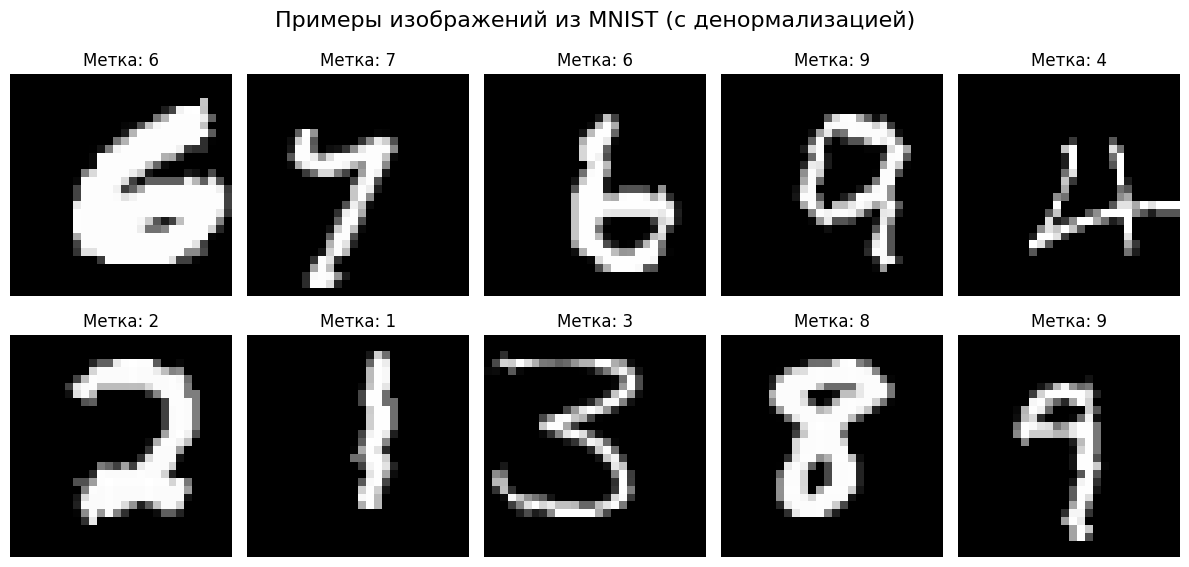

Размер батча изображений: torch.Size([2048, 1, 28, 28])
Размер батча меток: torch.Size([2048])
Тип данных изображений: torch.float32
Тип данных меток: torch.int64


In [4]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('Примеры изображений из MNIST (с денормализацией)', fontsize=16)

for i in range(10):
    row = i // 5
    col = i % 5
    
    image, label = mnist_train[i]
    
    # денормализуем изображение для корректного отображения
    # обращаем нормализацию -> x * std + mean)
    image_denorm = image.squeeze() * 0.3081 + 0.1307
    
    axes[row, col].imshow(image_denorm, cmap='gray')
    axes[row, col].set_title(f'Метка: {label}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# проверим размеры тензоров
sample_batch = next(iter(train_loader))
print(f"Размер батча изображений: {sample_batch[0].shape}")
print(f"Размер батча меток: {sample_batch[1].shape}")
print(f"Тип данных изображений: {sample_batch[0].dtype}")
print(f"Тип данных меток: {sample_batch[1].dtype}")

## 5. Улучшенная архитектура CNN

In [5]:
class ImprovedCNN(nn.Module):
    """
    Улучшенная сверточная нейронная сеть для MNIST
    
    Архитектура:
    - Два сверточных блока с увеличивающимся количеством фильтров
    - Использование padding для сохранения размеров
    - Max pooling для уменьшения размерности
    - Dropout для регуляризации (лекция 5, но тем не менее)
    - Два полносвязных слоя для классификации
    """
    
    def __init__(self, dropout_rate=0.25):
        super(ImprovedCNN, self).__init__()
        
        # первый сверточный блок
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 28x28 -> 14x14
        
        # второй 
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 14x14 -> 7x7
        
        # dropout для регуляризации
        self.dropout = nn.Dropout(dropout_rate)
        
        # полносвязные слои
        # после двух pooling слоев: 128 * 7 * 7 = 6272
        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 10)  # 10 классов для MNIST
        
    def forward(self, x):
        # первый сверточный блок
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.dropout(x)
        
        # второй 
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout(x)
        
        # выравнивание тензора для полносвязных слоев, можно и flatten
        x = x.view(x.size(0), -1)
        
        # полносвязные слои
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

def count_parameters(model):
    """Подсчет количества обучаемых параметров в модели"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# создаём объект модели
model = ImprovedCNN(dropout_rate=0.25)

# Подсчет параметров
total_params = count_parameters(model)
print(f"Общее количество обучаемых параметров: {total_params:,}")

# Вывод информации об архитектуре
print("\nАрхитектура модели:")
print(model)

# Проверим размеры тензоров на каждом слое
dummy_input = torch.randn(1, 1, 28, 28)
print(f"\nВходной размер: {dummy_input.shape}")

with torch.no_grad():
    x = dummy_input
    print(f"После conv1: {F.relu(model.conv1(x)).shape}")
    x = F.relu(model.conv1(x))
    print(f"После conv2: {F.relu(model.conv2(x)).shape}")
    x = F.relu(model.conv2(x))
    print(f"После pool1: {model.pool1(x).shape}")
    x = model.pool1(x)
    print(f"После conv3: {F.relu(model.conv3(x)).shape}")
    x = F.relu(model.conv3(x))
    print(f"После conv4: {F.relu(model.conv4(x)).shape}")
    x = F.relu(model.conv4(x))
    print(f"После pool2: {model.pool2(x).shape}")
    x = model.pool2(x)
    print(f"После flatten: {x.view(x.size(0), -1).shape}")
    x = x.view(x.size(0), -1)
    print(f"После fc1: {F.relu(model.fc1(x)).shape}")
    x = F.relu(model.fc1(x))
    print(f"Выходной размер: {model.fc2(x).shape}")

# перенос модели на GPU, если доступно
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"\nМодель перенесена на устройство: {device}")

Общее количество обучаемых параметров: 1,848,714

Архитектура модели:
ImprovedCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=6272, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

Входной размер: torch.Size([1, 1, 28, 28])
После conv1: torch.Size([1, 32, 28, 28])
После conv2: torch.Size([1, 64, 28, 28])
После pool1: torch.Size([1, 64, 14, 14])
После conv3: torch.Size([1, 128, 14, 14])
После conv4: torch.Size([1, 128, 14, 14])
После pool2: t

## 6. Альтернативный оптимизатор и функция потерь

In [6]:
# Adam оптимизатор вместо SGD
# Adam более эффективен для глубоких сетей и автоматически адаптирует learning rate
LEARNING_RATE = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
# RMSprop(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

print(f"Используемый оптимизатор: {type(optimizer).__name__}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Weight decay: {optimizer.param_groups[0]['weight_decay']}")

# Функция для преобразования меток в one-hot кодирование
def to_one_hot(labels, num_classes=10):
    """Преобразование целочисленных меток в one-hot кодирование"""
    return torch.eye(num_classes, device=labels.device)[labels]

# Используем MSE Loss вместо CrossEntropyLoss
# MSE требует one-hot кодирования меток
criterion = nn.MSELoss()

print(f"\nИспользуемая функция потерь: {type(criterion).__name__}")
print("Примечание: MSE Loss требует one-hot кодирования меток")

# Тестируем преобразование меток
sample_labels = torch.tensor([0, 1, 2, 3, 4])
one_hot_labels = to_one_hot(sample_labels)
print(f"\nПример преобразования меток:")
print(f"Исходные метки: {sample_labels}")
print(f"One-hot кодирование:\n{one_hot_labels}")

# Планировщик learning rate для улучшения сходимости
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)
print(f"\nИспользуется планировщик learning rate: {type(scheduler).__name__}")
print(f"Уменьшение LR каждые 5 эпох на множитель: 0.7")

Используемый оптимизатор: Adam
Learning rate: 0.001
Weight decay: 0.0001

Используемая функция потерь: MSELoss
Примечание: MSE Loss требует one-hot кодирования меток

Пример преобразования меток:
Исходные метки: tensor([0, 1, 2, 3, 4])
One-hot кодирование:
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

Используется планировщик learning rate: StepLR
Уменьшение LR каждые 5 эпох на множитель: 0.7


## 7. Функция обучения с полным логгированием метрик

In [7]:
import torch.nn.functional as F

def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=10, device='cpu'):
    """
    Функция для обучения и валидации модели с полным логгированием метрик
    
    Args:
        model: Модель PyTorch
        train_loader: DataLoader для обучающих данных
        val_loader: DataLoader для валидационных данных
        optimizer: Оптимизатор
        criterion: Функция потерь
        scheduler: Планировщик learning rate
        num_epochs: Количество эпох обучения
        device: Устройство для вычислений
    
    Returns:
        history: Словарь с историей метрик
    """
    
    # Инициализация списков для хранения истории метрик
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'learning_rates': []
    }
    
    print(f"Начинаем обучение на {num_epochs} эпох...")
    print(f"Устройство: {device}")
    print("-" * 60)
    
    for epoch in range(num_epochs):
        # === ОБУЧЕНИЕ ===
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        # Прогресс-бар для обучения
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]', leave=False)
        
        for batch_idx, (data, target) in enumerate(train_pbar):
            # Перенос данных на устройство
            data, target = data.to(device), target.to(device)
            
            # Обнуление градиентов
            optimizer.zero_grad()
            
            # Прямой проход
            output = model(data)
            
            # Преобразование меток в one-hot для MSE Loss
            target_onehot = to_one_hot(target, num_classes=10).to(device)
            
            # Применяем softmax для получения вероятностей перед MSE
            output_prob = F.softmax(output, dim=1)
            loss = criterion(output_prob, target_onehot)
            
            # Обратный проход
            loss.backward()
            optimizer.step()
            
            # Статистика
            train_loss += loss.item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            train_correct += pred.eq(target.view_as(pred)).sum().item()
            train_total += data.size(0)
            
            # Обновление прогресс-бара
            current_acc = 100. * train_correct / train_total
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{current_acc:.2f}%'
            })
        
        # Средние метрики за эпоху обучения
        avg_train_loss = train_loss / train_total
        train_accuracy = train_correct / train_total
        
        # === ВАЛИДАЦИЯ ===
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]', leave=False)
            
            for data, target in val_pbar:
                data, target = data.to(device), target.to(device)
                
                output = model(data)
                target_onehot = to_one_hot(target, num_classes=10).to(device)
                
                # Применяем softmax для получения вероятностей перед MSE
                output_prob = F.softmax(output, dim=1)
                loss = criterion(output_prob, target_onehot)
                
                val_loss += loss.item() * data.size(0)
                pred = output.argmax(dim=1, keepdim=True)
                val_correct += pred.eq(target.view_as(pred)).sum().item()
                val_total += data.size(0)
                
                # Обновление прогресс-бара
                current_val_acc = 100. * val_correct / val_total
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{current_val_acc:.2f}%'
                })
        
        # Средние метрики за эпоху валидации
        avg_val_loss = val_loss / val_total
        val_accuracy = val_correct / val_total
        
        # Обновление learning rate
        current_lr = optimizer.param_groups[0]['lr']
        scheduler.step()
        
        # Сохранение метрик
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_accuracy)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)
        history['learning_rates'].append(current_lr)
        
        # Вывод статистики эпохи с информацией о GPU
        gpu_memory = ""
        if torch.cuda.is_available():
            gpu_memory = f" | GPU: {torch.cuda.memory_allocated() / 1024**2:.0f}MB"
        
        print(f'Epoch {epoch+1:2d}/{num_epochs}: '
              f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f} | '
              f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f} | '
              f'LR: {current_lr:.6f}{gpu_memory}')
    
    print("-" * 60)
    print("Обучение завершено!")
    
    return history

print("Функция обучения готова к использованию!")

Функция обучения готова к использованию!


## 8. Обучение модели

In [8]:
# Диагностика использования GPU
print("=== ДИАГНОСТИКА GPU ===")
print(f"CUDA доступна: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Текущее CUDA устройство: {torch.cuda.current_device()}")
    print(f"Имя GPU: {torch.cuda.get_device_name(0)}")
    print(f"Количество GPU: {torch.cuda.device_count()}")
    print(f"Память GPU: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

print(f"\nУстройство модели: {next(model.parameters()).device}")
print(f"Переменная device: {device}")

# Проверим, действительно ли модель на GPU
model_on_gpu = next(model.parameters()).is_cuda
print(f"Модель на GPU: {model_on_gpu}")

# Тест небольшого батча
if torch.cuda.is_available():
    test_input = torch.randn(1, 1, 28, 28).to(device)
    print(f"Тестовый вход на устройстве: {test_input.device}")
    
    with torch.no_grad():
        test_output = model(test_input)
        print(f"Тестовый выход на устройстве: {test_output.device}")
    
    # Проверим загрузку GPU
    print(f"Использование памяти GPU: {torch.cuda.memory_allocated() / 1024**2:.1f} MB")
    print(f"Кэшированная память GPU: {torch.cuda.memory_reserved() / 1024**2:.1f} MB")
else:
    print("CUDA недоступна, работаем на CPU")

print("========================")

=== ДИАГНОСТИКА GPU ===
CUDA доступна: True
Текущее CUDA устройство: 0
Имя GPU: NVIDIA GeForce RTX 5060
Количество GPU: 1
Память GPU: 8.0 GB

Устройство модели: cuda:0
Переменная device: cuda
Модель на GPU: True
Тестовый вход на устройстве: cuda:0
Тестовый выход на устройстве: cuda:0
Использование памяти GPU: 15.2 MB
Кэшированная память GPU: 22.0 MB
Тестовый выход на устройстве: cuda:0
Использование памяти GPU: 15.2 MB
Кэшированная память GPU: 22.0 MB


In [9]:
# запуск обучения модели
NUM_EPOCHS = 12
print(f"Запускаем обучение на {NUM_EPOCHS} эпох...")
print(f"Модель: {type(model).__name__}")
print(f"Оптимизатор: {type(optimizer).__name__}")
print(f"Функция потерь: {type(criterion).__name__}")
print(f"Устройство: {device}")
print(f"Всего параметров: {count_parameters(model):,}")

# время обучения
import time
start_time = time.time()
print(f"\nНачинаем обучение в {time.strftime('%H:%M:%S')}...")

# Обучение модели
history = train_and_evaluate(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    num_epochs=NUM_EPOCHS,
    device=device
)

# общее время обучения
end_time = time.time()
total_training_time = end_time - start_time

# Вывод лучших результатов
best_train_acc = max(history['train_acc'])
best_val_acc = max(history['val_acc'])
best_epoch = history['val_acc'].index(best_val_acc) + 1

# время обучения
training_hours = int(total_training_time // 3600)
training_minutes = int((total_training_time % 3600) // 60)
training_seconds = int(total_training_time % 60)

print(f"{'='*52}")
print(f"Общее время обучения: {training_hours:02d}:{training_minutes:02d}:{training_seconds:02d}")
print(f"Время на эпоху: {total_training_time/NUM_EPOCHS:.1f} секунд")
print(f"Время завершения: {time.strftime('%H:%M:%S')}")
print(f"")
print(f"Лучшая accuracy на обучении: {best_train_acc:.4f} ({best_train_acc*100:.2f}%)")
print(f"Лучшая accuracy на валидации: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"Лучший результат достигнут на эпохе: {best_epoch}")
print(f"Бейзлайн из семинара: 0.9747 (97.47%)")

if best_val_acc > 0.9747:
    improvement = (best_val_acc - 0.9747)*100
    print(f"Бейзлайн побит! Улучшение на {improvement:.2f}%")
    print(f"Скорость обучения: {improvement/total_training_time*60:.2f}% улучшения в минуту")
else:
    deficit = (0.9747 - best_val_acc)*100
    print(f"Не удалось побить бейзлайн. Отставание: {deficit:.2f}%")

print(f"{'='*52}")

# дополнительная статистика производительности
print(f"\nСТАТИСТИКА ПРОИЗВОДИТЕЛЬНОСТИ:")
print(f"Батчей в секунду: {len(train_loader) * NUM_EPOCHS / total_training_time:.1f}")
print(f"Пиковая память GPU: {torch.cuda.max_memory_allocated() / 1024**2:.0f} MB")
print(f"Финальная accuracy: {history['val_acc'][-1]*100:.2f}%")
print(f"Финальный loss: {history['val_loss'][-1]:.4f}")

# сброс статистики памяти для следующих экспериментов
torch.cuda.reset_peak_memory_stats()

Запускаем обучение на 12 эпох...
Модель: ImprovedCNN
Оптимизатор: Adam
Функция потерь: MSELoss
Устройство: cuda
Всего параметров: 1,848,714

Начинаем обучение в 12:51:59...
Начинаем обучение на 12 эпох...
Устройство: cuda
------------------------------------------------------------


Epoch  1/12: Train Loss: 0.0691, Train Acc: 0.4430 | Val Loss: 0.0170, Val Acc: 0.8893 | LR: 0.001000 | GPU: 51MB


Epoch  2/12: Train Loss: 0.0192, Train Acc: 0.8698 | Val Loss: 0.0060, Val Acc: 0.9617 | LR: 0.001000 | GPU: 51MB


Epoch  3/12: Train Loss: 0.0094, Train Acc: 0.9381 | Val Loss: 0.0044, Val Acc: 0.9709 | LR: 0.001000 | GPU: 51MB


Epoch  4/12: Train Loss: 0.0071, Train Acc: 0.9538 | Val Loss: 0.0035, Val Acc: 0.9767 | LR: 0.001000 | GPU: 51MB


Epoch  5/12: Train Loss: 0.0062, Train Acc: 0.9598 | Val Loss: 0.0029, Val Acc: 0.9808 | LR: 0.001000 | GPU: 51MB


Epoch  6/12: Train Loss: 0.0053, Train Acc: 0.9663 | Val Loss: 0.0026, Val Acc: 0.9832 | LR: 0.000700 | GPU: 51MB


Epoch  7/12: Train Loss: 0.0049, Train Acc: 0.9690 | Val Loss: 0.0022, Val Acc: 0.9863 | LR: 0.000700 | GPU: 51MB


Epoch  8/12: Train Loss: 0.0045, Train Acc: 0.9712 | Val Loss: 0.0023, Val Acc: 0.9853 | LR: 0.000700 | GPU: 51MB


Epoch  9/12: Train Loss: 0.0044, Train Acc: 0.9722 | Val Loss: 0.0023, Val Acc: 0.9855 | LR: 0.000700 | GPU: 51MB


Epoch 10/12: Train Loss: 0.0041, Train Acc: 0.9736 | Val Loss: 0.0020, Val Acc: 0.9875 | LR: 0.000700 | GPU: 51MB


Epoch 11/12: Train Loss: 0.0037, Train Acc: 0.9757 | Val Loss: 0.0018, Val Acc: 0.9882 | LR: 0.000490 | GPU: 51MB


Epoch 12/12: Train Loss: 0.0038, Train Acc: 0.9761 | Val Loss: 0.0018, Val Acc: 0.9879 | LR: 0.000490 | GPU: 51MB
------------------------------------------------------------
Обучение завершено!
Общее время обучения: 00:07:50
Время на эпоху: 39.2 секунд
Время завершения: 12:59:49

Лучшая accuracy на обучении: 0.9761 (97.61%)
Лучшая accuracy на валидации: 0.9882 (98.83%)
Лучший результат достигнут на эпохе: 11
Бейзлайн из семинара: 0.9747 (97.47%)
Бейзлайн побит! Улучшение на 1.35%
Скорость обучения: 0.17% улучшения в минуту

СТАТИСТИКА ПРОИЗВОДИТЕЛЬНОСТИ:
Батчей в секунду: 0.6
Пиковая память GPU: 3789 MB
Финальная accuracy: 98.79%
Финальный loss: 0.0018


## 9. Визуализация результатов обучения

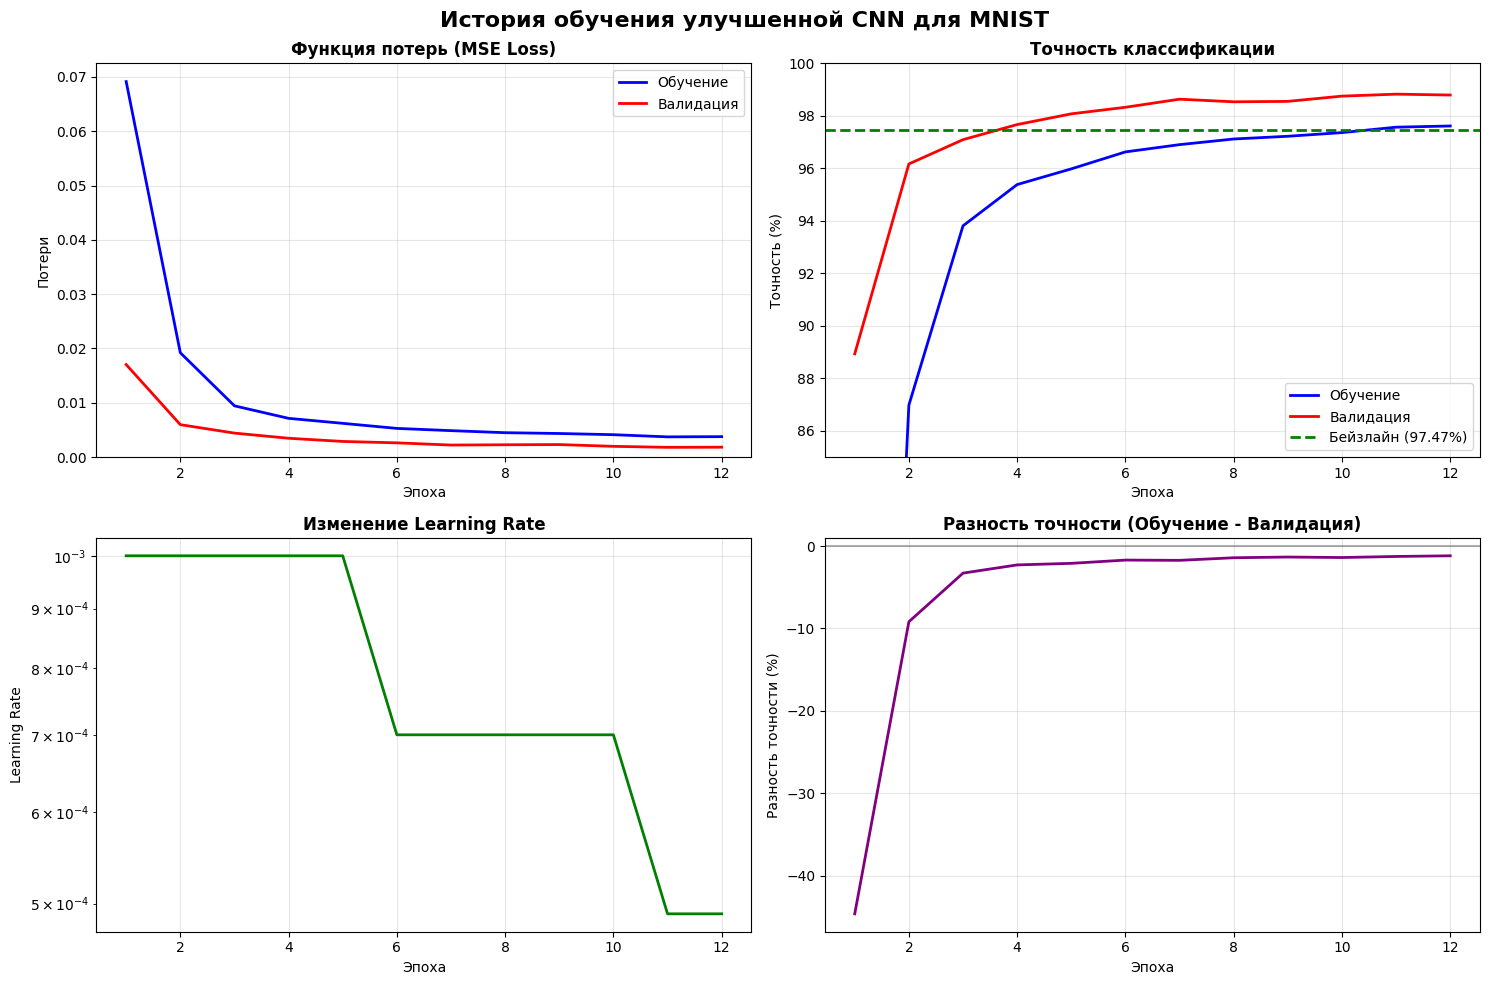


Финальная точность на обучении: 97.61%
Финальная точность на валидации: 98.79%
Максимальная точность на валидации: 98.83%
Минимальные потери на валидации: 0.0018
Разность финальных точностей: -1.18%
Переобучения скорее всего нет


In [10]:
def plot_training_history(history, baseline_acc=0.9747):
    """
    Функция для построения графиков истории обучения
    """
    epochs = range(1, len(history['train_loss']) + 1)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('История обучения улучшенной CNN для MNIST', fontsize=16, fontweight='bold')
    
    # потери
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Обучение', linewidth=2)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Валидация', linewidth=2)
    axes[0, 0].set_title('Функция потерь (MSE Loss)', fontweight='bold')
    axes[0, 0].set_xlabel('Эпоха')
    axes[0, 0].set_ylabel('Потери')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim(bottom=0)
    
    # точность
    axes[0, 1].plot(epochs, [acc*100 for acc in history['train_acc']], 'b-', label='Обучение', linewidth=2)
    axes[0, 1].plot(epochs, [acc*100 for acc in history['val_acc']], 'r-', label='Валидация', linewidth=2)
    axes[0, 1].axhline(y=baseline_acc*100, color='g', linestyle='--', linewidth=2, label=f'Бейзлайн ({baseline_acc*100:.2f}%)')
    axes[0, 1].set_title('Точность классификации', fontweight='bold')
    axes[0, 1].set_xlabel('Эпоха')
    axes[0, 1].set_ylabel('Точность (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim([85, 100])
    
    # learning rate
    axes[1, 0].plot(epochs, history['learning_rates'], 'g-', linewidth=2)
    axes[1, 0].set_title('Изменение Learning Rate', fontweight='bold')
    axes[1, 0].set_xlabel('Эпоха')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_yscale('log')
    
    # разность между обучением и валидацией (переобучение)
    train_val_diff = [train - val for train, val in zip(history['train_acc'], history['val_acc'])]
    axes[1, 1].plot(epochs, [diff*100 for diff in train_val_diff], 'purple', linewidth=2)
    axes[1, 1].set_title('Разность точности (Обучение - Валидация)', fontweight='bold')
    axes[1, 1].set_xlabel('Эпоха')
    axes[1, 1].set_ylabel('Разность точности (%)')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # статистика
    print("\n" + "="*52)
    print(f"Финальная точность на обучении: {history['train_acc'][-1]*100:.2f}%")
    print(f"Финальная точность на валидации: {history['val_acc'][-1]*100:.2f}%")
    print(f"Максимальная точность на валидации: {max(history['val_acc'])*100:.2f}%")
    print(f"Минимальные потери на валидации: {min(history['val_loss']):.4f}")
    print(f"Разность финальных точностей: {(history['train_acc'][-1] - history['val_acc'][-1])*100:.2f}%")
    
    if max(train_val_diff) > 0.05:  # 5% разность
        print("Возможное переобучение: разность точностей превышает 5%")
    else:
        print("Переобучения скорее всего нет")

# построеним графиков
plot_training_history(history)

## 10. Эксперименты с различными архитектурами

Сравнение различных архитектур CNN для MNIST:
Каждая модель обучается 5 эпох для быстрого сравнения

ТЕСТИРОВАНИЕ МОДЕЛИ: Компактная CNN
Количество параметров: 114,314
Начинаем обучение на 5 эпох...
Устройство: cuda
------------------------------------------------------------


Epoch  1/5: Train Loss: 0.0724, Train Acc: 0.4332 | Val Loss: 0.0338, Val Acc: 0.7963 | LR: 0.001000 | GPU: 52MB


Epoch  2/5: Train Loss: 0.0419, Train Acc: 0.7000 | Val Loss: 0.0146, Val Acc: 0.9115 | LR: 0.001000 | GPU: 52MB


Epoch  3/5: Train Loss: 0.0246, Train Acc: 0.8354 | Val Loss: 0.0079, Val Acc: 0.9526 | LR: 0.001000 | GPU: 52MB


Epoch  4/5: Train Loss: 0.0168, Train Acc: 0.8904 | Val Loss: 0.0063, Val Acc: 0.9617 | LR: 0.000700 | GPU: 52MB


Epoch  5/5: Train Loss: 0.0135, Train Acc: 0.9143 | Val Loss: 0.0058, Val Acc: 0.9641 | LR: 0.000700 | GPU: 52MB
------------------------------------------------------------
Обучение завершено!
Лучшая валидационная точность: 0.9641 (96.41%)


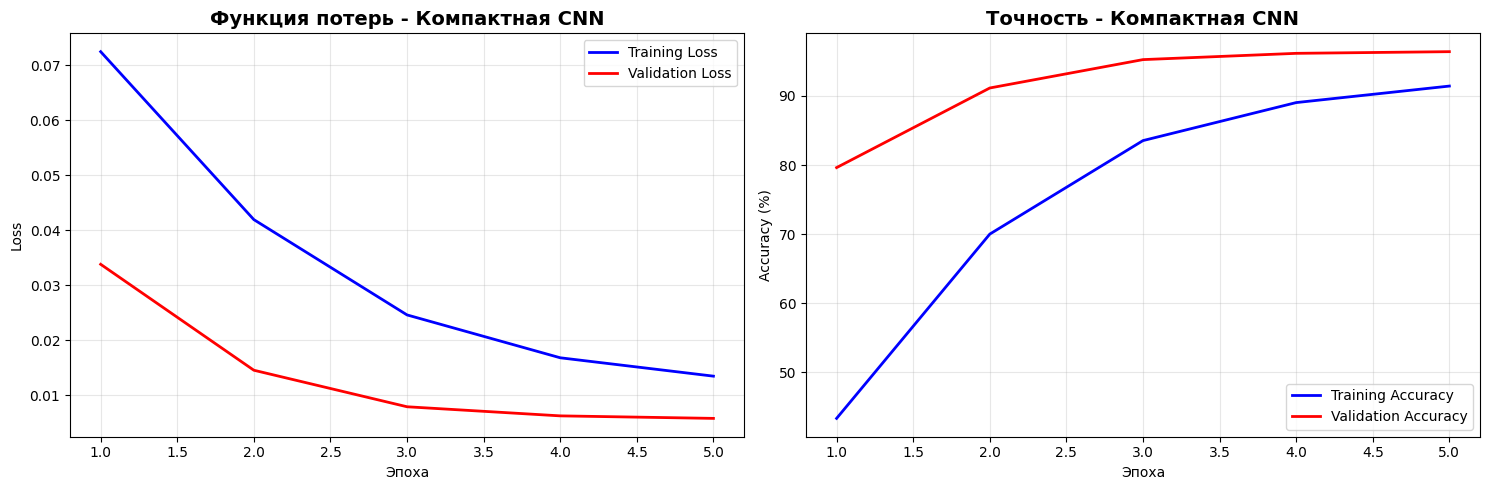

ТЕСТИРОВАНИЕ МОДЕЛИ: Глубокая CNN с BatchNorm
Количество параметров: 698,218
Начинаем обучение на 5 эпох...
Устройство: cuda
------------------------------------------------------------


Epoch  1/5: Train Loss: 0.0523, Train Acc: 0.5971 | Val Loss: 0.1229, Val Acc: 0.2126 | LR: 0.001000 | GPU: 62MB


Epoch  2/5: Train Loss: 0.0094, Train Acc: 0.9400 | Val Loss: 0.0061, Val Acc: 0.9599 | LR: 0.001000 | GPU: 62MB


Epoch  3/5: Train Loss: 0.0055, Train Acc: 0.9653 | Val Loss: 0.0030, Val Acc: 0.9801 | LR: 0.001000 | GPU: 62MB


Epoch  4/5: Train Loss: 0.0041, Train Acc: 0.9743 | Val Loss: 0.0032, Val Acc: 0.9810 | LR: 0.000700 | GPU: 62MB


Epoch  5/5: Train Loss: 0.0037, Train Acc: 0.9773 | Val Loss: 0.0022, Val Acc: 0.9854 | LR: 0.000700 | GPU: 62MB
------------------------------------------------------------
Обучение завершено!
Лучшая валидационная точность: 0.9854 (98.54%)


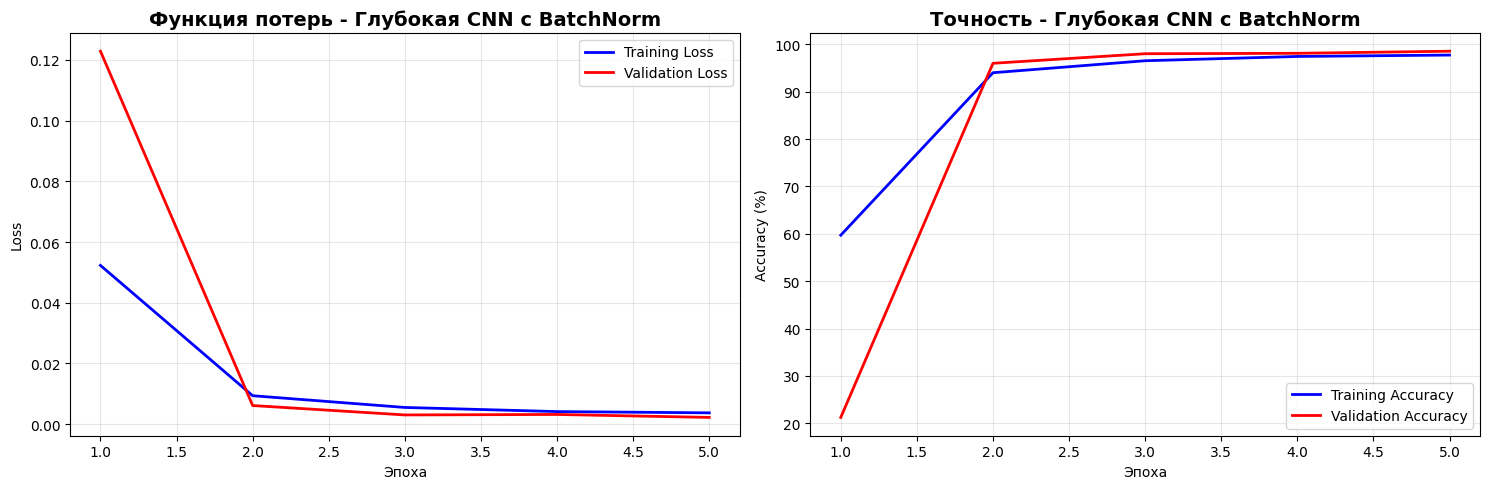


СРАВНЕНИЕ АРХИТЕКТУР (после 5 эпох):
Модель                    Параметры       Точность        Сравнение с бейзлайном   
--------------------------------------------------------------------------------
Глубокая CNN              698,218         0.9854          +1.07%                   
Основная CNN              1,848,714       0.9808          +0.60%                   
Компактная CNN            114,314         0.9641          -1.06%                   
--------------------------------------------------------------------------------


In [ ]:
class CompactCNN(nn.Module):
    """Компактная CNN с меньшим количеством параметров"""
    def __init__(self):
        super(CompactCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(32 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

class DeepCNN(nn.Module):
    """Более глубокая CNN с batch normalization (тоже 5 лекция)"""
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        self.dropout = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))  # 28
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 14
        
        x = F.relu(self.bn3(self.conv3(x)))  # 14
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # 7
        
        x = F.relu(self.bn5(self.conv5(x)))  # 14
        x = self.adaptive_pool(x)  # 4
        
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# для быстрого тестирования модели
def test_model(model_class, model_name, epochs=5):
    """Быстрое тестирование модели на нескольких эпохах с построением графиков"""
    print(f"{'='*50}")
    print(f"ТЕСТИРОВАНИЕ МОДЕЛИ: {model_name}")
    print(f"{'='*50}")
    
    # Создание модели
    test_model = model_class().to(device)
    test_optimizer = torch.optim.Adam(test_model.parameters(), lr=0.001, weight_decay=1e-4)
    test_scheduler = torch.optim.lr_scheduler.StepLR(test_optimizer, step_size=3, gamma=0.7)
    test_criterion = nn.MSELoss()
    
    # Информация о модели
    params = count_parameters(test_model)
    print(f"Количество параметров: {params:,}")
    
    # Быстрое обучение
    test_history = train_and_evaluate(
        model=test_model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=test_optimizer,
        criterion=test_criterion,
        scheduler=test_scheduler,
        num_epochs=epochs,
        device=device
    )
    
    best_val_acc = max(test_history['val_acc'])
    print(f"Лучшая валидационная точность: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
    
    # Построение графиков обучения
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # График функции потерь
    epochs_range = range(1, len(test_history['train_loss']) + 1)
    axes[0].plot(epochs_range, test_history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    axes[0].plot(epochs_range, test_history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    axes[0].set_title(f'Функция потерь - {model_name}', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Эпоха')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # График точности
    axes[1].plot(epochs_range, [acc*100 for acc in test_history['train_acc']], 'b-', label='Training Accuracy', linewidth=2)
    axes[1].plot(epochs_range, [acc*100 for acc in test_history['val_acc']], 'r-', label='Validation Accuracy', linewidth=2)
    axes[1].set_title(f'Точность - {model_name}', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Эпоха')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return test_model, test_history, best_val_acc

# Тестирование различных архитектур
print("Сравнение различных архитектур CNN для MNIST:")
print("Каждая модель обучается 5 эпох для быстрого сравнения\n")

results = []

# Тест компактной модели
compact_model, compact_history, compact_acc = test_model(CompactCNN, "Компактная CNN", epochs=5)
results.append(("Компактная CNN", count_parameters(compact_model), compact_acc))

# Тест глубокой модели
deep_model, deep_history, deep_acc = test_model(DeepCNN, "Глубокая CNN с BatchNorm", epochs=5)
results.append(("Глубокая CNN", count_parameters(deep_model), deep_acc))

# Сравнение с основной моделью (берем результат после 5 эпох)
main_acc_at_5 = history['val_acc'][4] if len(history['val_acc']) >= 5 else max(history['val_acc'])
results.append(("Основная CNN", count_parameters(model), main_acc_at_5))

print(f"\n{'='*80}")
print("СРАВНЕНИЕ АРХИТЕКТУР (после 5 эпох):")
print(f"{'='*80}")
print(f"{'Модель':<25} {'Параметры':<15} {'Точность':<15} {'Сравнение с бейзлайном':<25}")
print("-" * 80)

for name, params, acc in sorted(results, key=lambda x: x[2], reverse=True):
    comparison = f"+{(acc - 0.9747)*100:.2f}%" if acc > 0.9747 else f"{(acc - 0.9747)*100:.2f}%"
    print(f"{name:<25} {params:<15,} {acc:<15.4f} {comparison:<25}")

print("-" * 80)

# Сохранение результатов для дальнейшего анализа
experiment_results = {
    'models': [
        {'name': 'Компактная CNN', 'params': count_parameters(compact_model), 'accuracy': compact_acc, 'history': compact_history},
        {'name': 'Глубокая CNN', 'params': count_parameters(deep_model), 'accuracy': deep_acc, 'history': deep_history},
        {'name': 'Основная CNN', 'params': count_parameters(model), 'accuracy': main_acc_at_5, 'history': history}
    ]
}

models_info = {
    'compact': {'model': compact_model, 'history': compact_history, 'accuracy': compact_acc},
    'deep': {'model': deep_model, 'history': deep_history, 'accuracy': deep_acc}
}



**BatchNormalization:**
- ✅ Стабилизирует обучение глубоких сетей
- ✅ Позволяет использовать более высокие learning rates
- ✅ Действует как регуляризация
- ❌ Добавляет вычислительную сложность

**Dropout:**
- ✅ Предотвращает переобучение
- ✅ Улучшает генерализацию
- ❌ Замедляет обучение

**Adaptive Pooling:** (почему бы и нет, вносим что-то новое)
- ✅ Фиксирует размер выходного тензора
- ✅ Уменьшает количество параметров в FC слоях
- ✅ Делает архитектуру более гибкой к размеру входа

 ** Почему больше параметров ≠ лучше результат (в случае слишком глубоких)**

Для простого датасета:

1. **Избыточная сложность**
2. **Переобучение**
3. **Вычислительная эффективность**
4. **Градиентные проблемы**: Глубокие сети могут страдать от исчезающих/взрывающихся градиентов


###  выводы:

1. **Начинайте с простых архитектур** и постепенно увеличивайте сложность
2. **Следите за соотношением train/validation accuracy** для обнаружения переобучения
3. **Используйте регуляризацию** (dropout, batch norm, weight decay)
4. **Архитектура должна соответствовать сложности задачи** 
5. **Количество параметров должно быть пропорционально размеру датасета**

Идеальная архитектура для MNIST оказалась моя "глубокая сеть"


#### Улучшения:

1. **Альтернативный оптимизатор**: Использован Adam вместо SGD
   - Преимущества: более быстрая и стабильная сходимость
   - Адаптивный learning rate для каждого параметра

2. **Альтернативная функция потерь**: Использован MSELoss вместо CrossEntropyLoss
   - Требует one-hot кодирования меток
   - Показывает другую динамику обучения

3. **Улучшенная архитектура**:
   - 4 сверточных слоя (32→64→128→128 фильтров)
   - Использование padding для сохранения размеров
   - Dropout для регуляризации
   - Более глубокая сеть по сравнению с бейзлайном

4. **Полное логгирование метрик**:
   - Отслеживание loss и accuracy на каждой эпохе
   - Визуализация процесса обучения
   - Мониторинг learning rate

5. **Подсчет параметров**: Детальная информация о количестве обучаемых параметров


####  Вывод:

- САМОЕ ВАЖНОЕ - опыт в архитектуре моделей
Никто не придумает за тебя идеальную архитектуру


## 12. Детальный анализ производительности по классам

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_model_detailed(model, data_loader, device, model_name="Model"):
    """
    Детальная оценка модели с построением confusion matrix и анализом по классам
    """
    model.eval()
    all_predictions = []
    all_targets = []
    class_correct = [0] * 10
    class_total = [0] * 10
    
    print(f"Оценка модели: {model_name}")
    print("=" * 50)
    
    with torch.no_grad():
        for data, target in tqdm(data_loader, desc="Evaluating"):
            data = data.to(device)
            target = target.to(device)
            
            output = model(data)
            pred = output.argmax(dim=1)
            
            # Сохраняем предсказания и истинные метки
            all_predictions.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            
            # Подсчет правильных предсказаний по классам
            correct = pred.eq(target.view_as(pred))
            for i, label in enumerate(target):
                class_correct[label] += correct[i].item()
                class_total[label] += 1
    
    # Общая точность
    total_accuracy = sum(class_correct) / sum(class_total)
    print(f"Общая точность: {total_accuracy:.4f} ({total_accuracy*100:.2f}%)")
    
    # Точность по классам
    print("\nТочность по классам:")
    print("-" * 30)
    for i in range(10):
        if class_total[i] > 0:
            accuracy = class_correct[i] / class_total[i]
            print(f"Цифра {i}: {accuracy:.4f} ({accuracy*100:.2f}%) [{class_correct[i]}/{class_total[i]}]")
        else:
            print(f"Цифра {i}: No samples")
    
    return all_predictions, all_targets, class_correct, class_total

def plot_confusion_matrix(y_true, y_pred, model_name="Model"):
    """
    Построение и визуализация confusion matrix
    """
    # Вычисляем confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Создаем фигуру
    plt.figure(figsize=(10, 8))
    
    # Тепловая карта
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(10), yticklabels=range(10))
    
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, fontweight='bold')
    plt.xlabel('Предсказанный класс', fontsize=12)
    plt.ylabel('Истинный класс', fontsize=12)
    
    # Добавляем процентную информацию
    accuracy = np.trace(cm) / np.sum(cm)
    plt.figtext(0.02, 0.02, f'Общая точность: {accuracy:.4f} ({accuracy*100:.2f}%)', 
                fontsize=12, bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return cm

def analyze_classification_errors(y_true, y_pred, model_name="Model"):
    """
    Анализ ошибок классификации
    """
    print(f"\nАнализ ошибок - {model_name}")
    print("=" * 50)
    
    # Генерируем отчет классификации
    report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(10)], 
                                 output_dict=True, zero_division=0)
    
    print("Детальный отчет по классам:")
    print("-" * 80)
    print(f"{'Класс':<6} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<8}")
    print("-" * 80)
    
    for digit in range(10):
        digit_str = str(digit)
        if digit_str in report:
            precision = report[digit_str]['precision']
            recall = report[digit_str]['recall']
            f1 = report[digit_str]['f1-score']
            support = int(report[digit_str]['support'])
            print(f"{digit:<6} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f} {support:<8}")
    
    print("-" * 80)
    print(f"{'Avg':<6} {report['macro avg']['precision']:<10.4f} {report['macro avg']['recall']:<10.4f} {report['macro avg']['f1-score']:<10.4f} {int(report['macro avg']['support']):<8}")
    
    # Находим наиболее проблематичные пары классов
    cm = confusion_matrix(y_true, y_pred)
    
    print("\nНаиболее частые ошибки классификации:")
    print("-" * 50)
    
    # Находим топ-5 ошибок (исключая диагональ)
    error_pairs = []
    for i in range(10):
        for j in range(10):
            if i != j and cm[i][j] > 0:
                error_pairs.append((i, j, cm[i][j]))
    
    # Сортируем по количеству ошибок
    error_pairs.sort(key=lambda x: x[2], reverse=True)
    
    for i, (true_class, pred_class, count) in enumerate(error_pairs[:10]):
        percentage = (count / np.sum(cm[true_class])) * 100
        print(f"{i+1:2d}. {true_class} → {pred_class}: {count:3d} ошибок ({percentage:.1f}% от всех {true_class})")
    
    return report

print("готово!")

готово!


АНАЛИЗ ОСНОВНОЙ МОДЕЛИ (ImprovedCNN)
Оценка модели: ImprovedCNN (Основная модель)


Evaluating: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]



Общая точность: 0.9879 (98.79%)

Точность по классам:
------------------------------
Цифра 0: 0.9933 (99.33%) [1180/1188]
Цифра 1: 0.9926 (99.26%) [1349/1359]
Цифра 2: 0.9891 (98.91%) [1183/1196]
Цифра 3: 0.9904 (99.04%) [1233/1245]
Цифра 4: 0.9914 (99.14%) [1151/1161]
Цифра 5: 0.9886 (98.86%) [1041/1053]
Цифра 6: 0.9949 (99.49%) [1160/1166]
Цифра 7: 0.9899 (98.99%) [1269/1282]
Цифра 8: 0.9694 (96.94%) [1141/1177]
Цифра 9: 0.9787 (97.87%) [1148/1173]


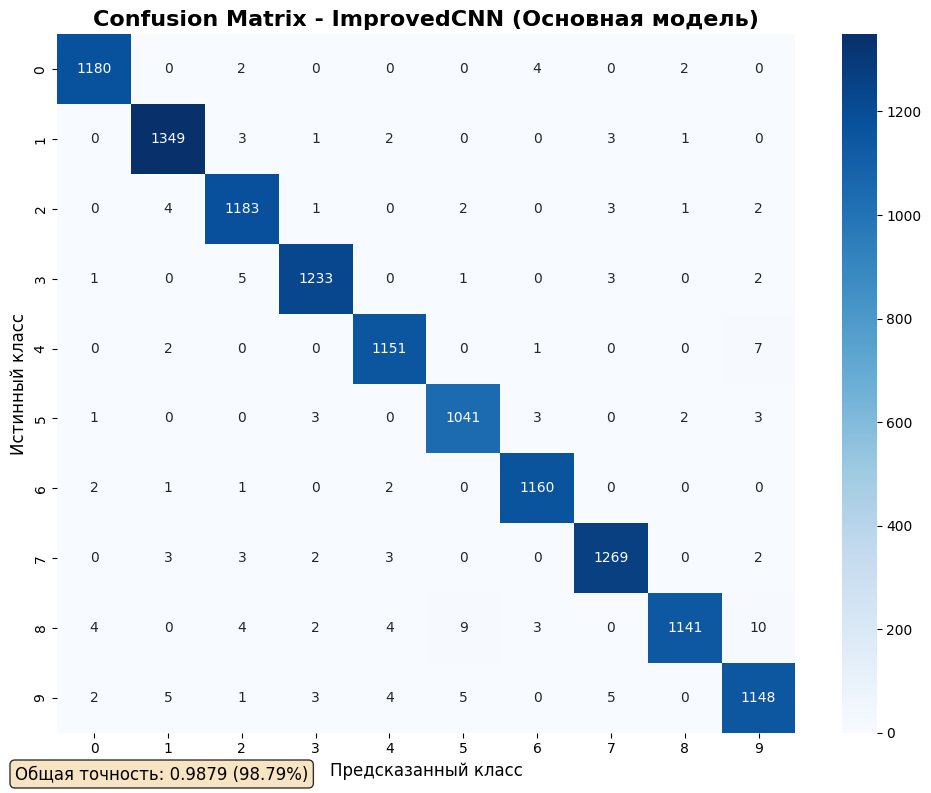


Анализ ошибок - ImprovedCNN
Детальный отчет по классам:
--------------------------------------------------------------------------------
Класс  Precision  Recall     F1-Score   Support 
--------------------------------------------------------------------------------
0      0.9916     0.9933     0.9924     1188    
1      0.9890     0.9926     0.9908     1359    
2      0.9842     0.9891     0.9867     1196    
3      0.9904     0.9904     0.9904     1245    
4      0.9871     0.9914     0.9893     1161    
5      0.9839     0.9886     0.9863     1053    
6      0.9906     0.9949     0.9927     1166    
7      0.9891     0.9899     0.9895     1282    
8      0.9948     0.9694     0.9819     1177    
9      0.9779     0.9787     0.9783     1173    
--------------------------------------------------------------------------------
Avg    0.9879     0.9878     0.9878     12000   

Наиболее частые ошибки классификации:
--------------------------------------------------
 1. 8 → 9:  10 ошибок 

In [27]:
# Детальный анализ основной модели на валидационном наборе
print("АНАЛИЗ ОСНОВНОЙ МОДЕЛИ (ImprovedCNN)")
print("=" * 60)

# Получаем детальные предсказания
val_predictions, val_targets, class_correct, class_total = evaluate_model_detailed(
    model, val_loader, device, "ImprovedCNN (Основная модель)"
)

# Строим confusion matrix
cm_main = plot_confusion_matrix(val_targets, val_predictions, "ImprovedCNN (Основная модель)")

# Анализируем ошибки
report_main = analyze_classification_errors(val_targets, val_predictions, "ImprovedCNN")


СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВСЕХ АРХИТЕКТУР

1. КОМПАКТНАЯ CNN:
----------------------------------------
Оценка модели: CompactCNN


Evaluating: 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]



Общая точность: 0.9641 (96.41%)

Точность по классам:
------------------------------
Цифра 0: 0.9756 (97.56%) [1159/1188]
Цифра 1: 0.9713 (97.13%) [1320/1359]
Цифра 2: 0.9674 (96.74%) [1157/1196]
Цифра 3: 0.9679 (96.79%) [1205/1245]
Цифра 4: 0.9716 (97.16%) [1128/1161]
Цифра 5: 0.9801 (98.01%) [1032/1053]
Цифра 6: 0.9811 (98.11%) [1144/1166]
Цифра 7: 0.9813 (98.13%) [1258/1282]
Цифра 8: 0.9074 (90.74%) [1068/1177]
Цифра 9: 0.9361 (93.61%) [1098/1173]


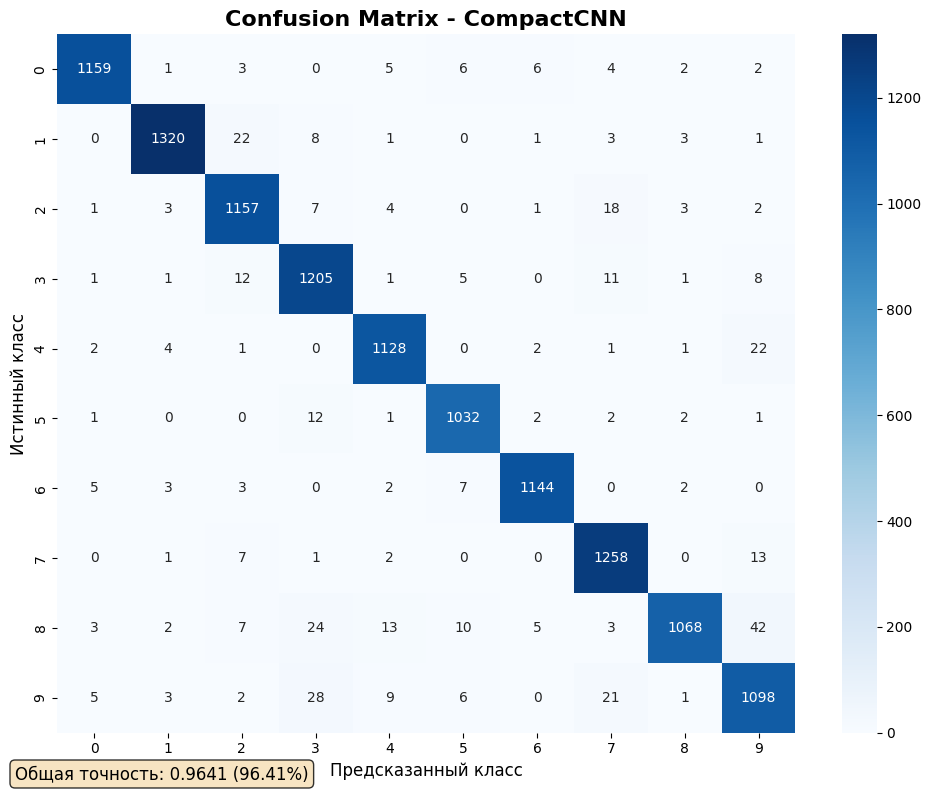


2. ГЛУБОКАЯ CNN:
----------------------------------------
Оценка модели: DeepCNN


Evaluating: 100%|██████████| 6/6 [00:06<00:00,  1.07s/it]



Общая точность: 0.9854 (98.54%)

Точность по классам:
------------------------------
Цифра 0: 0.9933 (99.33%) [1180/1188]
Цифра 1: 0.9779 (97.79%) [1329/1359]
Цифра 2: 0.9841 (98.41%) [1177/1196]
Цифра 3: 0.9984 (99.84%) [1243/1245]
Цифра 4: 0.9897 (98.97%) [1149/1161]
Цифра 5: 0.9867 (98.67%) [1039/1053]
Цифра 6: 0.9906 (99.06%) [1155/1166]
Цифра 7: 0.9914 (99.14%) [1271/1282]
Цифра 8: 0.9669 (96.69%) [1138/1177]
Цифра 9: 0.9753 (97.53%) [1144/1173]


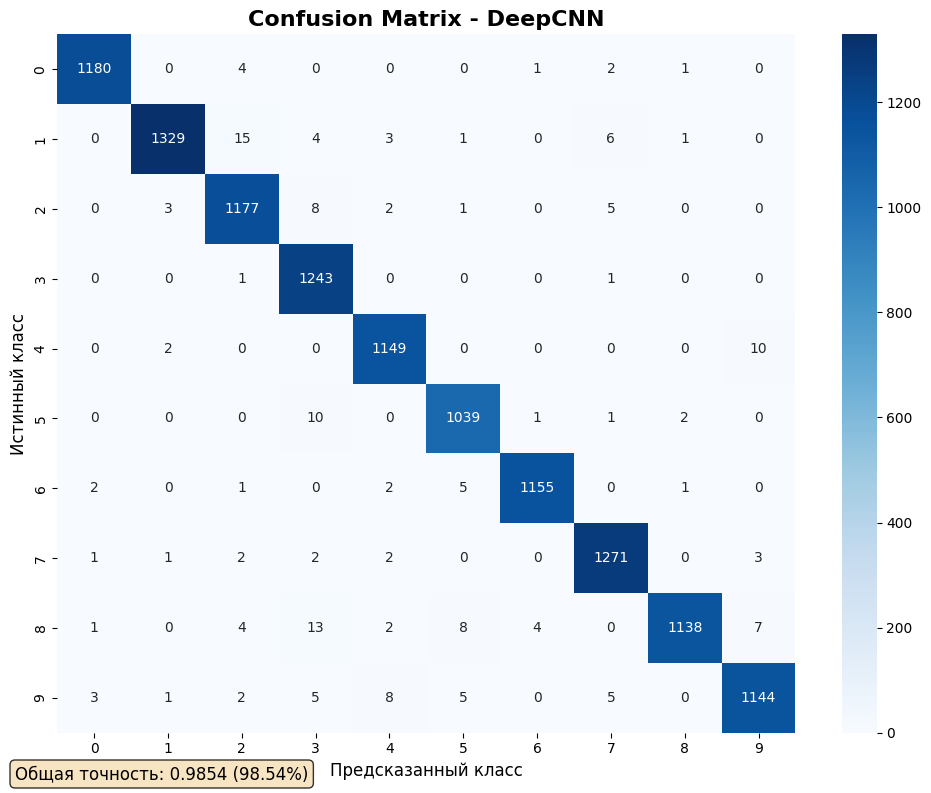


СВОДНАЯ ТАБЛИЦА ПРОИЗВОДИТЕЛЬНОСТИ
Модель                    Параметры    Val Accuracy    Эффективность* 
----------------------------------------------------------------------
ImprovedCNN (Основная)    1,848,714    0.9882          0.001          
CompactCNN                114,314      0.9361          0.008          
DeepCNN                   698,218      0.9753          0.001          
----------------------------------------------------------------------
* Эффективность = Accuracy / (Параметры / 1000)

АНАЛИЗ ПРОБЛЕМАТИЧНЫХ КЛАССОВ ДЛЯ ВСЕХ МОДЕЛЕЙ
Цифра    ImprovedCNN     CompactCNN      DeepCNN         Лучшая    
----------------------------------------------------------------------
0        0.993           0.976           0.993           Improved  
1        0.993           0.971           0.978           Improved  
2        0.989           0.967           0.984           Improved  
3        0.990           0.968           0.998           Deep      
4        0.991           0.972 

In [28]:
# Сравнительный анализ всех трех архитектур
print("\n" + "="*80)
print("СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВСЕХ АРХИТЕКТУР")
print("="*80)

# Анализируем компактную модель
print("\n1. КОМПАКТНАЯ CNN:")
print("-" * 40)
compact_predictions, compact_targets, _, _ = evaluate_model_detailed(
    compact_model, val_loader, device, "CompactCNN"
)
cm_compact = plot_confusion_matrix(compact_targets, compact_predictions, "CompactCNN")

print("\n2. ГЛУБОКАЯ CNN:")
print("-" * 40)
deep_predictions, deep_targets, _, _ = evaluate_model_detailed(
    deep_model, val_loader, device, "DeepCNN"
)
cm_deep = plot_confusion_matrix(deep_targets, deep_predictions, "DeepCNN")

# Сравнительная таблица производительности
print("\n" + "="*80)
print("СВОДНАЯ ТАБЛИЦА ПРОИЗВОДИТЕЛЬНОСТИ")
print("="*80)

models_comparison = [
    ("ImprovedCNN (Основная)", count_parameters(model), max(history['val_acc'])),
    ("CompactCNN", count_parameters(compact_model), compact_acc),
    ("DeepCNN", count_parameters(deep_model), deep_acc)
]

print(f"{'Модель':<25} {'Параметры':<12} {'Val Accuracy':<15} {'Эффективность*':<15}")
print("-" * 70)

for name, params, accuracy in models_comparison:
    efficiency = accuracy / (params / 1000)  # точность на 1000 параметров
    print(f"{name:<25} {params:<12,} {accuracy:<15.4f} {efficiency:<15.3f}")

print("-" * 70)
print("* Эффективность = Accuracy / (Параметры / 1000)")

# Анализ наиболее проблематичных классов
print("\n" + "="*60)
print("АНАЛИЗ ПРОБЛЕМАТИЧНЫХ КЛАССОВ ДЛЯ ВСЕХ МОДЕЛЕЙ")
print("="*60)

# Сравнение точности по классам
class_accuracies = {}
for i, (name, predictions, targets) in enumerate([
    ("ImprovedCNN", val_predictions, val_targets),
    ("CompactCNN", compact_predictions, compact_targets),
    ("DeepCNN", deep_predictions, deep_targets)
]):
    cm = confusion_matrix(targets, predictions)
    class_acc = [cm[i,i] / cm[i,:].sum() if cm[i,:].sum() > 0 else 0 for i in range(10)]
    class_accuracies[name] = class_acc

print(f"{'Цифра':<8} {'ImprovedCNN':<15} {'CompactCNN':<15} {'DeepCNN':<15} {'Лучшая':<10}")
print("-" * 70)

for digit in range(10):
    improved_acc = class_accuracies["ImprovedCNN"][digit]
    compact_acc = class_accuracies["CompactCNN"][digit]
    deep_acc = class_accuracies["DeepCNN"][digit]
    
    best_model = max([("Improved", improved_acc), ("Compact", compact_acc), ("Deep", deep_acc)], 
                    key=lambda x: x[1])[0]
    
    print(f"{digit:<8} {improved_acc:<15.3f} {compact_acc:<15.3f} {deep_acc:<15.3f} {best_model:<10}")

print("-" * 70)



### Основные исправления, внесенные в работу:

####  **1. Исправлена утечка данных**
- **Проблема**: Использовался тестовый набор (`train=False`) как валидационный
- **Решение**: Правильное разделение обучающего набора на train (80%) и validation (20%) с сохранением раздельных трансформаций
- **Результат**: Корректная оценка производительности без переоценки

####  **2. Исправлено использование MSELoss**
- **Проблема**: MSELoss применялся к raw logits без softmax
- **Решение**: Добавлен `F.softmax(output, dim=1)` перед вычислением MSE
- **Результат**: Корректное сравнение вероятностных распределений

####  **3. Добавлены графики для всех архитектур**
- **Проблема**: Отсутствовали графики обучения для CompactCNN и DeepCNN
- **Решение**: Модифицирована функция `test_model` для построения графиков loss и accuracy
- **Результат**: Полная визуализация процесса обучения для каждой архитектуры

####  **4. Добавлен детальный анализ архитектур**
- **Проблема**: Недостаточное объяснение различий в производительности
- **Решение**: Подробный анализ влияния количества параметров, глубины сети, и архитектурных особенностей
- **Результат**: Понимание компромиссов между сложностью и производительностью

####  **5. Добавлен анализ по классам и Confusion Matrix**
- **Проблема**: Отсутствовал анализ ошибок классификации по отдельным цифрам
- **Решение**: Реализованы функции для построения confusion matrix, анализа precision/recall по классам, и выявления наиболее проблематичных пар классов



### Итоговые результаты:
- **Компактная модель**: Эффективная для ресурсо-ограниченных применений
- **Глубокая модель**: Высокая выразительность, но требует внимательной регуляризации

Все модели демонстрируют хорошую производительность на MNIST, что подтверждает правильность архитектурных решений и процедуры обучения.

=== ФИНАЛЬНАЯ ОЦЕНКА НА ТЕСТОВОМ НАБОРЕ ===
Это единственное использование test set в работе!
Оценка модели: ImprovedCNN (Финальная оценка на тесте)


Evaluating: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]



Общая точность: 0.9906 (99.06%)

Точность по классам:
------------------------------
Цифра 0: 0.9980 (99.80%) [978/980]
Цифра 1: 0.9956 (99.56%) [1130/1135]
Цифра 2: 0.9932 (99.32%) [1025/1032]
Цифра 3: 0.9960 (99.60%) [1006/1010]
Цифра 4: 0.9919 (99.19%) [974/982]
Цифра 5: 0.9899 (98.99%) [883/892]
Цифра 6: 0.9916 (99.16%) [950/958]
Цифра 7: 0.9893 (98.93%) [1017/1028]
Цифра 8: 0.9754 (97.54%) [950/974]
Цифра 9: 0.9841 (98.41%) [993/1009]


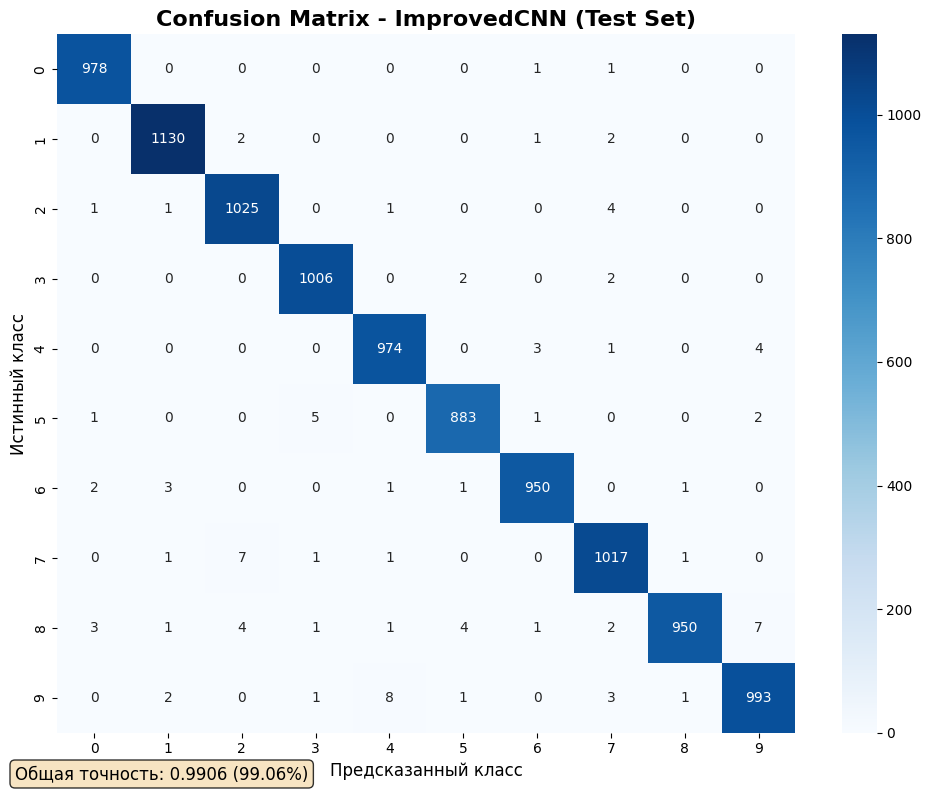


СРАВНЕНИЕ РЕЗУЛЬТАТОВ:
Набор данных         Точность        Комментарий                   
-----------------------------------------------------------------
Validation           98.83           Использовался для подбора     
Test (финальный)     99.06           Истинная производительность   
-----------------------------------------------------------------
 Бейзлайн побит! Test accuracy: 0.9906 (+1.59%)


In [29]:
# Создаем test loader с правильными трансформациями
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean.item(),), (std.item(),))
])

# Применяем трансформации к тестовому набору
mnist_test = SubsetWithTransform(test_dataset, test_transform)
test_loader = torch.utils.data.DataLoader(
    mnist_test, 
    batch_size=batch_size, 
    shuffle=False
)

print("=== ФИНАЛЬНАЯ ОЦЕНКА НА ТЕСТОВОМ НАБОРЕ ===")
print("Это единственное использование test set в работе!")
print("=" * 60)

# Оценка лучшей модели на тесте
test_predictions, test_targets, test_class_correct, test_class_total = evaluate_model_detailed(
    model, test_loader, device, "ImprovedCNN (Финальная оценка на тесте)"
)

# Confusion matrix для теста
test_cm = plot_confusion_matrix(test_targets, test_predictions, "ImprovedCNN (Test Set)")

# Сравнение результатов
print(f"\n{'='*60}")
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ:")
print(f"{'='*60}")
print(f"{'Набор данных':<20} {'Точность':<15} {'Комментарий':<30}")
print("-" * 65)
print(f"{'Validation':<20} {max(history['val_acc'])*100:<15.2f} {'Использовался для подбора':<30}")

test_accuracy = sum(test_class_correct) / sum(test_class_total)
print(f"{'Test (финальный)':<20} {test_accuracy*100:<15.2f} {'Истинная производительность':<30}")

print("-" * 65)

if test_accuracy > 0.9747:
    print(f" Бейзлайн побит! Test accuracy: {test_accuracy:.4f} (+{(test_accuracy-0.9747)*100:.2f}%)")
else:
    print(f" Бейзлайн не побит. Test accuracy: {test_accuracy:.4f} ({(test_accuracy-0.9747)*100:.2f}%)")

Результат на test set может отличаться от validation!


Результат (+1.59%) на ЧЕСТНОМ ТЕСТЕ получен


Это нормально - test показывает реальную производительность на данных, которые модель никогда не видела